# Read in Hourly Air Data
Yo Kimura generated files that have hourly air measures. Files are very large. Need to see if it is possible to read them in and clean them.

Help from MS Copilot LLM
Annual Inhaled Mass (AIM): How much of the chemical a person would inhale if they stayed in that cell all year. (µg)

Annual Absorbed Dose Index (ADI): How much is taken up into blood (not just inhaled). (µg)

Also may make sense to just sum across all of the values for each grid cell - or each hour for each grid cell

Question - if we know pressure and temperature and the age of the person we could be more detailed in AIM and ADI.



## Description of Program
- program:    ip1_2cv1_HourlyAir
- task:       Read Air files with hourly data
- Version:    2026-01-09
- v2:         Consolidate code and prepare to loop
- v3:         Explore options for aggregated annual values
- project:    Southeast Texas Urban Integrated Field Lab
- funding:	  DOE
- author:     Nathanael Rosenheim

## Step 0: Good Housekeeping

In [1]:
# 1. Import all packages
import pandas as pd     # For obtaining and cleaning tabular data
import os # For saving output to path
import zipfile # For handling zip files

In [2]:
# 2. Check versions
import sys
print("Python Version     ", sys.version)
print("geopandas version: ", pd.__version__)

Python Version      3.13.9 | packaged by conda-forge | (main, Oct 22 2025, 23:12:41) [MSC v.1944 64 bit (AMD64)]
geopandas version:  2.3.3


In [3]:
# 3. Check working directory
# Get information on current working directory (getcwd)
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\GitHub\\integrate_people_theme1_cookbook'

In [4]:
#4. Store Program Name for output files to have the same name
programname = "ip1_2cv3_hourlyair"
# Make directory to save output
if not os.path.exists(programname):
    os.mkdir(programname)

# Step 1: Obtain Data
Obtain CSV Files

Posted CSV dump of the camx model ouput.
https://utexas.app.box.com/folder/359619230313

Nathanael saved an example file (a small one) on his local machine.

# Step 2: Clean Data

In [5]:
def obtain_hourly_air_quality_data(folder_name, pollutant_name="benz", resolution="1km"):
    # read in csv file from SourceData\Kimura_Hourly_2026-01-08\hourly_benz_1km.zip
    zip_path = os.path.join("SourceData", folder_name, f"hourly_{pollutant_name}_{resolution}.zip")
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(f'hourly_{pollutant_name}_{resolution}.csv') as f:
            hourly_df = pd.read_csv(f)

    return hourly_df

hourly_benz_df = obtain_hourly_air_quality_data("Kimura_Hourly_2026-01-08", pollutant_name="benz", resolution="1km")


In [6]:
hourly_benz_df.head()

,TSTEP,ROW,COL,tstamp,y,x,latitude,longitude,BENZ
0,0,0,0,2019-04-01 00:00:00-06:00,-1222.0,110.0,0.0,0.0,0.000016
1,0,0,1,2019-04-01 00:00:00-06:00,-1222.0,114.0,0.0,0.0,0.000017
2,0,0,2,2019-04-01 00:00:00-06:00,-1222.0,118.0,0.0,0.0,0.000018
3,0,0,3,2019-04-01 00:00:00-06:00,-1222.0,122.0,0.0,0.0,0.000020
4,0,0,4,2019-04-01 00:00:00-06:00,-1222.0,126.0,0.0,0.0,0.000020


In [7]:
# Adjust 
hourly_benz_df[['TSTEP','BENZ']].describe().T

,count,mean,std,min,25%,50%,75%,max
TSTEP,26625024.0,2567.500000,1482.635491,0.000000e+00,1283.750000,2567.500000,3851.250000,5135.000000
BENZ,26625024.0,0.000025,0.000040,9.795119e-09,0.000006,0.000014,0.000031,0.020884


In [8]:
# how many hours are in the data?
hourly_benz_df['tstamp'].nunique()

5136

In [9]:
5136/24

214.0

In [10]:
# Group by ROW and COL and sum the BENZ values
summed_benz_df = hourly_benz_df.groupby(['ROW', 'COL'])['BENZ'].sum().reset_index()

# Display the first few rows of the new dataframe
summed_benz_df.head()

,ROW,COL,BENZ
0,0,0,0.085695
1,0,1,0.085111
2,0,2,0.084533
3,0,3,0.083564
4,0,4,0.081309


In [11]:
# Get unique ROW, COL, x, and y combinations from the original dataframe
coords_df = hourly_benz_df[['ROW', 'COL', 'x', 'y']].drop_duplicates()

# Merge the coordinates back into the summed dataframe
summed_benz_with_coords_df = pd.merge(summed_benz_df, coords_df, on=['ROW', 'COL'])

# convert ROW and COL to integer
summed_benz_with_coords_df['ROW'] = summed_benz_with_coords_df['ROW'].astype(int)
summed_benz_with_coords_df['COL'] = summed_benz_with_coords_df['COL'].astype(int)

# Display the first few rows of the merged dataframe
summed_benz_with_coords_df.head()

,ROW,COL,BENZ,x,y
0,0,0,0.085695,110.0,-1222.0
1,0,1,0.085111,114.0,-1222.0
2,0,2,0.084533,118.0,-1222.0
3,0,3,0.083564,122.0,-1222.0
4,0,4,0.081309,126.0,-1222.0


In [12]:
# descriptive stats for BENZ
summed_benz_with_coords_df['BENZ'].describe().T

count    5184.000000
mean        0.126581
std         0.058076
min         0.071658
25%         0.092274
50%         0.120551
75%         0.142251
max         1.251789
Name: BENZ, dtype: float64

In [25]:
# add unique id based off ROW and COL
def generate_grid_id(row, col, resolution="1km"):
    return f"airuifl_{resolution}_{int(row):04d}_{int(col):04d}"

summed_benz_with_coords_df['grid_id'] = summed_benz_with_coords_df.apply(lambda row: 
                            generate_grid_id(row['ROW'], row['COL'], resolution="1km"), 
                            axis=1)
summed_benz_with_coords_df.head() 

,ROW,COL,BENZ,x,y,grid_id
0,0,0,0.085695,110.0,-1222.0,airuifl_1km_0000_0000
1,0,1,0.085111,114.0,-1222.0,airuifl_1km_0000_0001
2,0,2,0.084533,118.0,-1222.0,airuifl_1km_0000_0002
3,0,3,0.083564,122.0,-1222.0,airuifl_1km_0000_0003
4,0,4,0.081309,126.0,-1222.0,airuifl_1km_0000_0004


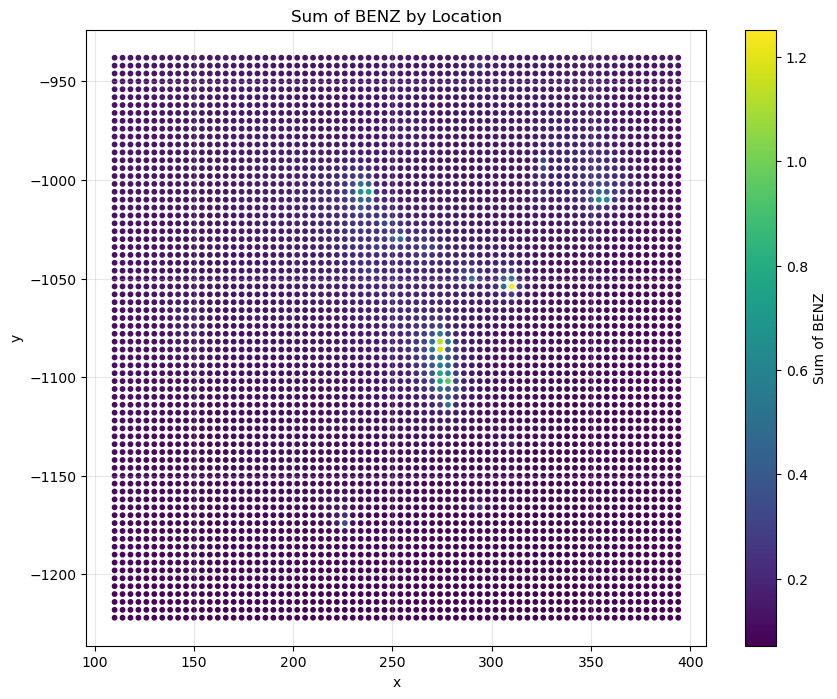

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(summed_benz_with_coords_df['x'], summed_benz_with_coords_df['y'], c=summed_benz_with_coords_df['BENZ'], cmap='viridis', s=10)
plt.colorbar(label='Sum of BENZ')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sum of BENZ by Location')
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
# output to csv
summed_benz_with_coords_df.to_csv(os.path.join(programname, f"{programname}_summed_benz_1km.csv"), index=False)

**LISA Analysis Summary**

LISA (Local Indicators of Spatial Association) identifies spatial clusters:
- **Hot spots (High-High)**: High values surrounded by high neighbors
- **Cold spots (Low-Low)**: Low values surrounded by low neighbors  
- **Outliers**: High-Low or Low-High combinations

**Why LISA for benzene grid data?**
- Grid structure is ideal for neighbor definitions
- Provides statistical significance testing
- Standard method in environmental epidemiology

**Implementation**: Use PySAL library (`esda.Moran_Local()` with `libpysal.weights.lat2W()` for grid weights)

In [16]:
# Import spatial analysis libraries
import geopandas as gpd
from libpysal.weights import lat2W
from esda.moran import Moran, Moran_Local
import numpy as np

# Import custom LISA analysis functions
from ip1_3cv1_LISA_analysis import (
    create_spatial_weights,
    create_spatial_weights_knn,
    calculate_global_morans_i,
    plot_morans_i_scatterplot,
    calculate_local_morans_i,
    plot_lisa_cluster_map
)

In [17]:
w, df_sorted = create_spatial_weights(summed_benz_with_coords_df)

Grid dimensions: 72 rows x 72 columns
Number of observations: 5184
Average number of neighbors: 7.83


In [18]:
df_sorted.head()

,ROW,COL,BENZ,x,y,grid_id
0,0,0,0.085695,110.0,-1222.0,air1km_0000_0000
1,0,1,0.085111,114.0,-1222.0,air1km_0000_0001
2,0,2,0.084533,118.0,-1222.0,air1km_0000_0002
3,0,3,0.083564,122.0,-1222.0,air1km_0000_0003
4,0,4,0.081309,126.0,-1222.0,air1km_0000_0004


In [19]:
moran_global = calculate_global_morans_i(df_sorted, 'BENZ', w)

Global Moran's I: 0.7848
Expected I: -0.0002
p-value: 0.0010
z-score: 109.0930

Result: Significant positive spatial autocorrelation (clustering)


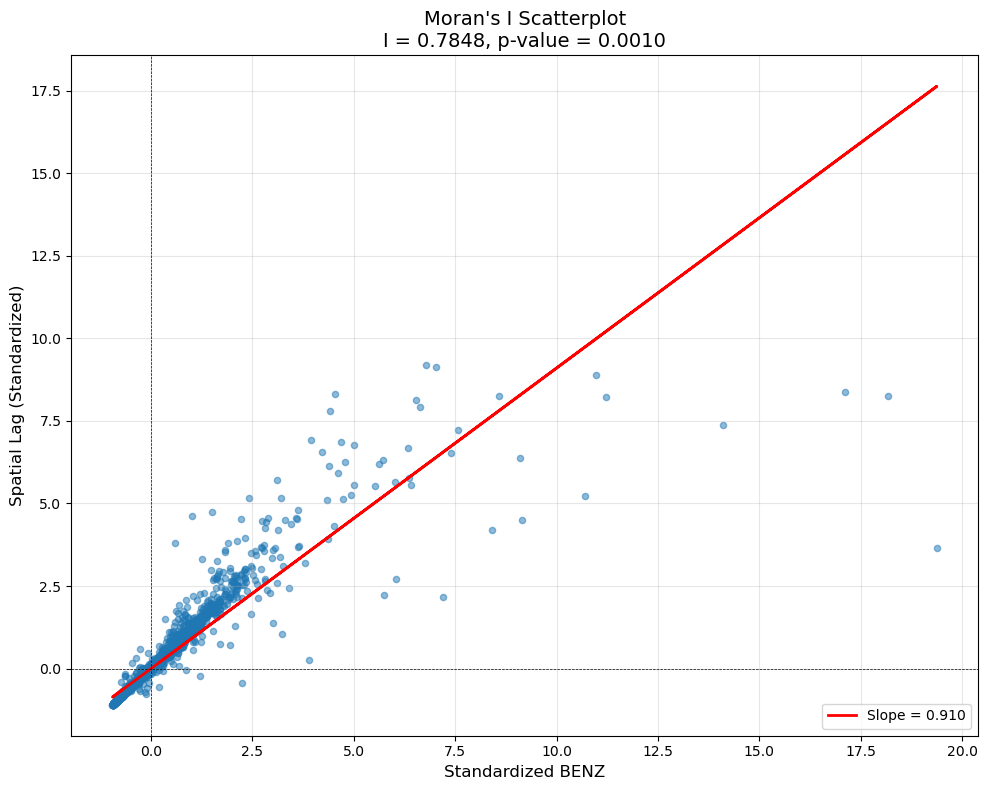

In [20]:
plot_morans_i_scatterplot(df_sorted, 'BENZ', w, moran_global)

In [21]:
df_sorted, moran_local = calculate_local_morans_i(df_sorted, 'BENZ', w, significance_level=0.05)

LISA Cluster Summary:
cluster_label
Not significant    2840
LL (Cold spot)     1696
HH (Hot spot)       647
HL                    1
Name: count, dtype: int64

Total significant clusters: 2344 (45.2%)


In [22]:
df_sorted.head()

,ROW,COL,BENZ,x,y,grid_id,moran_local_i,moran_p_value,moran_quadrant,significant,cluster_label
0,0,0,0.085695,110.0,-1222.0,air1km_0000_0000,0.493009,0.022,3,True,LL (Cold spot)
1,0,1,0.085111,114.0,-1222.0,air1km_0000_0001,0.503371,0.001,3,True,LL (Cold spot)
2,0,2,0.084533,118.0,-1222.0,air1km_0000_0002,0.519693,0.001,3,True,LL (Cold spot)
3,0,3,0.083564,122.0,-1222.0,air1km_0000_0003,0.546302,0.001,3,True,LL (Cold spot)
4,0,4,0.081309,126.0,-1222.0,air1km_0000_0004,0.587693,0.001,3,True,LL (Cold spot)


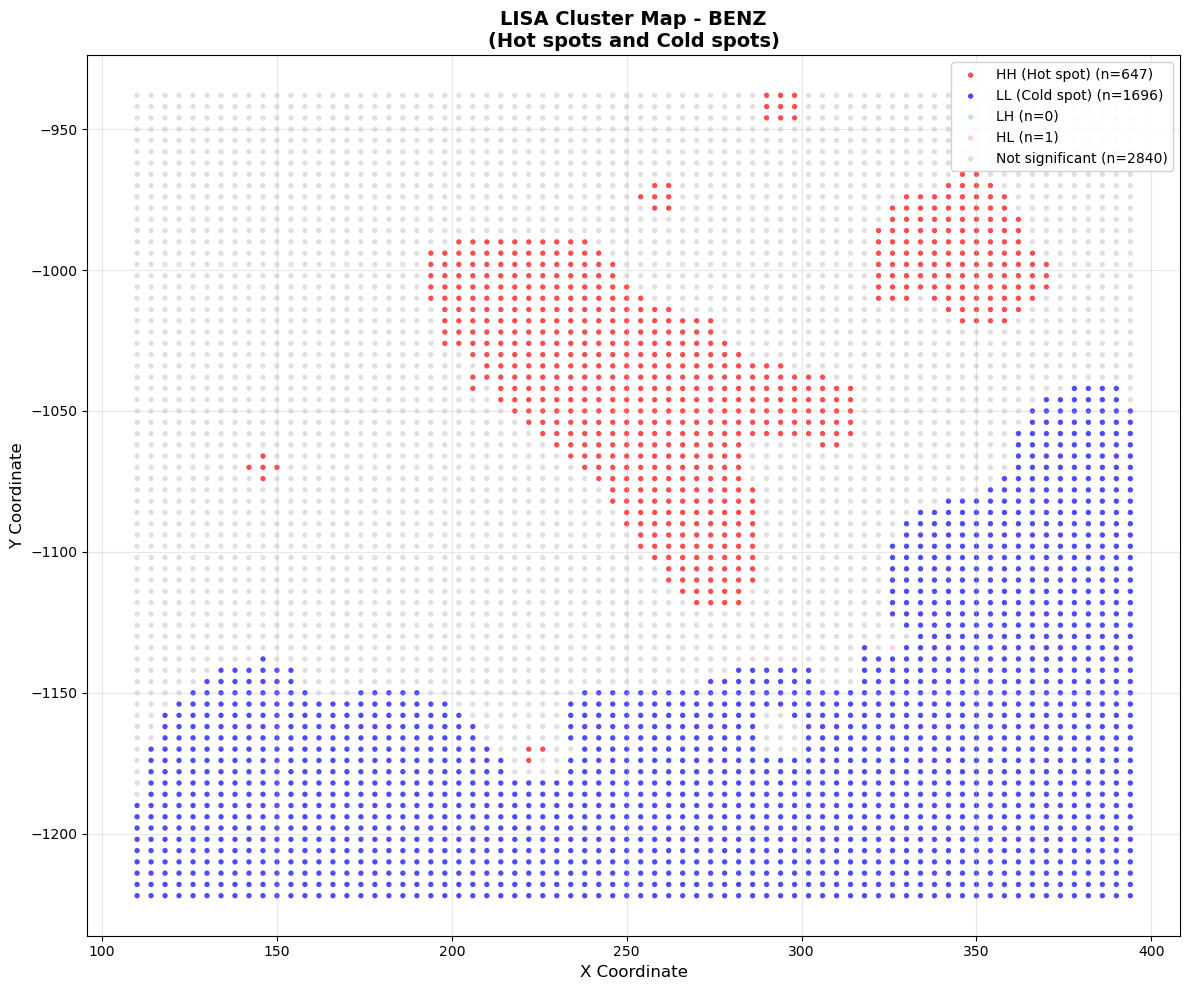

In [23]:
plot_lisa_cluster_map(df_sorted, 'BENZ')

c:\Users\nathanael99\AppData\Local\miniconda3\envs\ip1\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Number of observations: 3488
K-nearest neighbors: 8
Average number of neighbors: 8.00
LISA Cluster Summary:
cluster_label
Not significant    2061
LL (Cold spot)     1030
HH (Hot spot)       393
HL                    3
LH                    1
Name: count, dtype: int64

Total significant clusters: 1427 (40.9%)


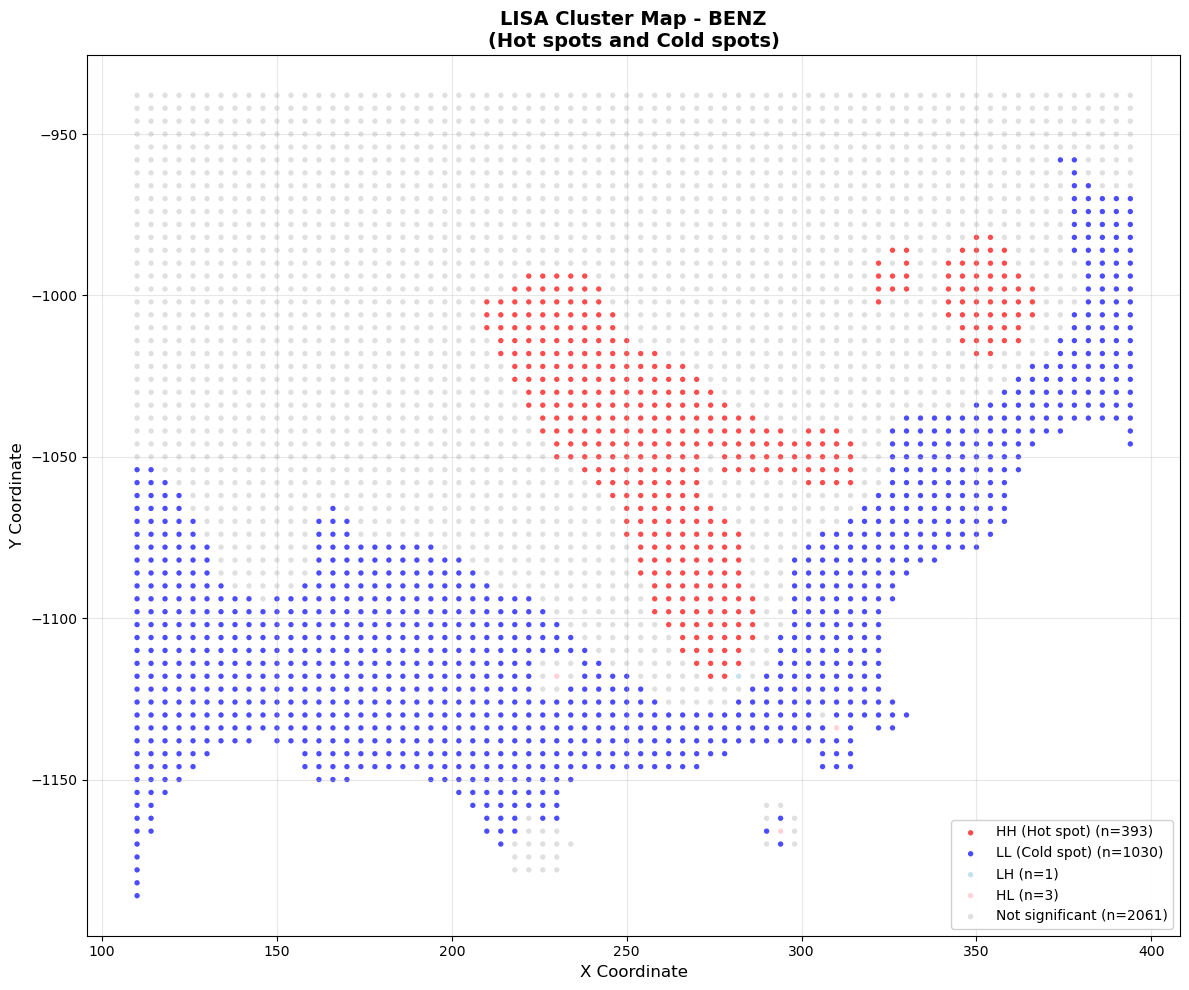

In [24]:
# Run without cold spots from round 1 (remove ocean to see what happens)
df_sorted_no_ocean = df_sorted[~df_sorted['cluster_label'].isin(['LL (Cold spot)'])].copy()
# Use KNN weights instead of grid-based weights since we filtered cells
w_knn, df_sorted_no_ocean = create_spatial_weights_knn(df_sorted_no_ocean, x_col='x', y_col='y', k=8)
df_sorted_no_ocean, moran_local_no_ocean = calculate_local_morans_i(df_sorted_no_ocean, 'BENZ', w_knn, significance_level=0.05)
plot_lisa_cluster_map(df_sorted_no_ocean, 'BENZ')